In [85]:
# load the audio files, and give each noise a label
# we'll assume each file contains multiple, spaced reptitions of the same noise
from pydub import AudioSegment
noise_audio = {
    't': AudioSegment.from_file('laptop_mic_t.wav'),
    'p': AudioSegment.from_file('laptop_mic_p.wav')
}

# get some basic properties
frame_rate = { n: noise_audio[n].frame_rate for n in noise_audio }
print("Frame rates:", frame_rate)
# print(noise_t_audio.duration_seconds)
# print(noise_t_audio.duration_seconds * noise_t_audio.frame_rate == noise_t_audio.frame_count())
# print(noise_t_audio.sample_width)
# print(noise_t_audio.channels)

# convert to mono, so each frame has only one sample
noise_audio_mono = { n: noise_audio[n].set_channels(1) for n in noise_audio }

# finally, convert to a more workable data type
import pandas as pd
noise_sample_array = {n: noise_audio_mono[n].get_array_of_samples() for n in noise_audio }
noise_series = { n: pd.Series(noise_sample_array[n], name=n) for n in noise_audio }

noises = pd.concat(noise_series.values(), axis=1)

Frame rates: {'t': 44100, 'p': 44100}


In [128]:
# We may need these later
import numpy as np
import matplotlib.pyplot as plt

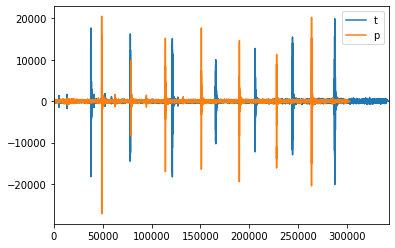

In [89]:
# visualize, to make sure things are sensible so far
noises.plot()

Zooming in on a couple representative spikes, we see they
* are quite distinct, 
* begin abruptly, and 
* last <~ 2000 frames ~ 0.05s

Duration shown: 0.045351473922902494


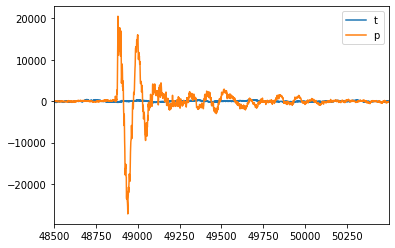

<Figure size 432x288 with 0 Axes>

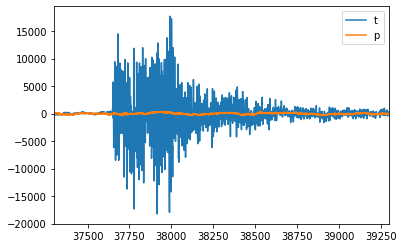

In [163]:
start    = 48500
duration = 2000
noises[start:start+duration].plot()
print("Duration shown:", duration / frame_rate['t'])

start    = 37300
plt.figure()
noises[start:start+duration].plot()

We want to isolate each of these spikes from the recording automatically, as individual "observations" of the desired noise. To do so we need to estimate when each noise starts, and how long it lasts. We'll assume short, percussive noises for now (not drawn out, like a hisssss).

{'t': 4027.0, 'p': 5443.200000000001}


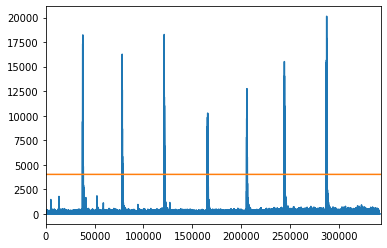

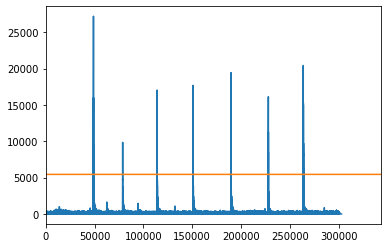

In [177]:
# To isolate the spikes, look for points with (absolute value) at least 20% of the maximum (absolute value)
SPIKE_THRESHOLD_FRACTION = .2
noises_abs = noises.apply(abs)
spike_thresholds = { n: noises_abs[n].max() * SPIKE_THRESHOLD_FRACTION for n in noises }
print(spike_thresholds)

# How does this look?


for n in noises:
    plt.figure()
    noises_abs[n].plot()
    
    x = range(len(noises))
    yval = spike_thresholds[n]
    plt.plot(x, [yval] * len(x), label=n)

Let's find where each spike begins, according to this threshold. We'll look for the first frame index after a gap of at least 0.1 seconds.

In [186]:
# for example, the first index of the series below is the first frame that meets the threshold.
# eventually there will be a gap in the frame indices, before the next spike
noises_abs.t[noises_abs.t > spike_thresholds['t']].head()

37652    5708
37656    6166
37660    5633
37662    6109
37663    9418
Name: t, dtype: int16

In [193]:
spike_first_indices = { n: [] for n in noises }
GAP_TIME = 0.1

for n in noises:
    # find all frames that meet the threshold
    threshold_filter = noises_abs[n] > spike_thresholds[n]
    meets_threshold = noises_abs[n].loc[threshold_filter]
    
    # the first spike is at the beginning
    spike_first_indices[n].append(meets_threshold.index[0])

    # find subsequent spikes by looking for gaps in the frame indices
    gap_size = GAP_TIME * frame_rate[n]
    i = 1
    while i < len(meets_threshold):
        if meets_threshold.index[i] - meets_threshold.index[i-1] > gap_size:
            spike_first_indices[n].append(meets_threshold.index[i])
        i += 1

In [195]:
# How many spikes did we find?
print({ n: len(v) for (n,v) in spike_first_indices.items() })
print(spike_first_indices)

{'t': 7, 'p': 7}
{'t': [37652, 77971, 121017, 165541, 205670, 244153, 287362], 'p': [48880, 78837, 114116, 150959, 189831, 228031, 263794]}


This agrees with a visual inspection of the graphs, above.

Now, as a first attempt, let's pick some manual offsets to look before and after each spike index, to capture the full volume spike of each noise.

In [204]:
BEFORE = 0.002 # seconds
AFTER  = 0.03 # seconds

# Uncomment the below to see that these offsets capture the volume spikes well.

# for n in noises:
#     b = round(BEFORE * frame_rate[n])
#     a = round(AFTER  * frame_rate[n])
#     for s in spike_first_indices[n]:
#         plt.figure()
#         noises[n].iloc[ s-b : s+a ].plot()